In [152]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score
import pickle
import time
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev
import pandas as pd

In [3]:
def noise_to_signal(X, M, Ω):
    return np.sqrt(np.sum((Ω*X - Ω*M)**2) / np.sum((Ω*M)**2))

In [4]:
def abs_mean(X, M, Ω):
    return np.sum(np.abs((X-M)*Ω)) / np.sum(Ω)

In [5]:
## least-squares solved via single SVD
def SVD(M,r): #input matrix M, approximating with rank r
    u,s,vh = np.linalg.svd(M, full_matrices=False) #s is diag
    X = u[:,:r].dot(np.diag(np.sqrt(s[:r])))
    Y = vh[:r,:].T.dot(np.diag(np.sqrt(s[:r])))
    return X.dot(Y.T), X, Y## least-squares solved via single SVD

In [6]:
def L2_error(s, r):
    '''
        s: a vector
        compute the L2 norm for the vector s[r:] 
    '''
    return np.sqrt(np.mean(s[r:]**2))

def L1_error(s, r):
    '''
        s: a vector
        compute the L2 norm for the vector s[r:] 
    '''
    return np.mean(np.abs(s[r:]))

## Our Algorithm

### Input:

- O: the observation
- Z: the treatment pattern
- $\lambda$: the parameter for nuclear norm

### Output:
The goal is to minimize
$$
\min_{M,\tau} \frac{1}{2p}\|P_{\Omega}(O-M-\tau Z)\|_{F}^2 + \lambda \| M\|_{*} 
$$

We do this by implementing an iterative algorithm:

- $M_0 = 0, \tau_0 = 0, t = 0$
- $t = t + 1$
- $M_t = \text{soft_thresholding}(O-\tau Z, \lambda)$ 
- $\tau_{t} = <Z,O-M_t>/\|Z\|_{F}^2$
- Until $|\tau_{t} - \tau_{t-1}| < 1e-5$

In [506]:
def convex_algorithm(O, Ω, Z, l):
    tau = 0
    M = Ω*O
    num_treat = np.sum(Ω*Z)
    for T in range(2000):
        ## update M
        u,s,vh = np.linalg.svd(Ω*(O - tau*Z) + (1-Ω)*M, full_matrices=False)
        #print(s)
        s = np.maximum(s-l, 0)
        M = (u*s).dot(vh)
        #print(s)
        
        tau_new = np.sum(Ω*Z * (O - M)) / num_treat # update tau
        #print('tau(t) is {}, tau(t+1) is {}'.format(tau, tau_new))
        if (np.abs(tau_new - tau) < 1e-4):
            return M, tau, 'successful'
        tau = tau_new
    return M, tau, 'fail'

def tune_convex_algorithm_with_rank(O, Z, suggest_r = 1):
    c = np.sqrt(min(O.shape[0], O.shape[1]))
    c = c * np.mean(O) / 5
    l = c
    while (True):
        M, tau, info = convex_algorithm(O, np.ones_like(O), Z, l)
        print(info, l, np.linalg.matrix_rank(M))
        if (info != 'fail' and np.linalg.matrix_rank(M) <= suggest_r):
            tau_debias = debias(M, tau, Z, l)
            break
        l = l * 1.1
    return M, tau, tau_debias

In [475]:
def debias(M, tau, Z, l):
    u, s, vh = np.linalg.svd(M, full_matrices = False)
    r = np.linalg.matrix_rank(M)
    #print(s[:r+1], r)
    u = u[:, :r]
    vh = vh[:r, :]
    t1 = l * np.sum(Z*u.dot(vh))
    PZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))
    t2 = np.sum(PZ**2)
    #print(t1, t2)
    return tau - t1 / t2

In [230]:
def ideal_algorithm(E, Z):
    num_treat = np.sum(Z)
    return np.sum(Z*E) / num_treat

## Soft-Impute (Bayati etc. 2016 algorithm)


### Input:
        
- O: the observation
- Ω: the set of no-treatment (Ω = 1 - Z)
- l: the parameter for nuclear norm minimization

### Output:

#### Without fixed effects

solve the optimization:
Let p be the observation probability: $ p =|\Omega| / \text{np.size}(O)$,
\begin{align}
\min_{M} \frac{1}{2p} \|P_{\Omega}(O-M)\|_{F}^2 + \lambda \|M\|_{*}
\end{align}

We do this by iteration (soft_impute)

- $M_0 = 0$
- $M_t = \text{soft_thresholding}(Ω*O + (1-Ω)*M, \lambda * p)$

After convergence, obtaining $M$, Let
$$
\tau = <1-Ω, O-M> / \|1-Ω\|_{F}^2
$$

#### With fixed effects

solve the optimization
\begin{align}
\min_{M} \frac{1}{2p} \|P_{\Omega}(O - a1^{T} - 1b^{T} - M)\|_{F}^2 + \lambda \|M\|_{*}
\end{align}

We do this by:

- $M_0 = 0, a^0 = 0, b^0 = 0$
- fix $a^t, b^t$, solve $M_t = \text{soft_thresholding}(Ω*(O-a^t1^{T}-1b^{tT}) + (1-Ω)*M, \lambda * p)$
- fix $M_t$, solve the following convex optimization
$$
\min_{a \in R^{n}, b \in R^{n}} \sum_{(i,j)\in \Omega} (O_{ij}-M_{t,ij} - a_{i} - b_{j})^2
$$

we solve the above by iteration again (one may change to solve a linear system by considering the first-order condition, not sure which one is quicker)
- fix $b$, 
$$ 
a_i = \frac{\sum_{j, (i,j) \in \Omega} O_{ij} - M_{t,ij} - b_{j}}{\sum_{j, (i, j) \in \Omega} 1}
$$
- fix $a$
$$
b_j = \frac{\sum_{i, (i,j) \in \Omega} O_{ij} - M_{t,ij} - a_{i}}{\sum_{i, (i, j) \in \Omega} 1}
$$


In [507]:
def missing_algorithm(O, Ω, l, fixed_effects=False):
    M = np.zeros_like(O)
    total_element = np.size(O)
    p = np.sum(Ω) / total_element

    n1 = O.shape[0]
    n2 = O.shape[1]

    a = np.zeros((n1,1)) #row fixed effects
    b = np.zeros((n2,1)) #column fixed effects
    one_row = np.ones((1, n2))
    one_col = np.ones((n1, 1))
    Ω_row_sum = np.sum(Ω, axis = 1).reshape((n1, 1))
    Ω_column_sum = np.sum(Ω, axis = 0).reshape((n2, 1))
    for T in range(2000):
        # update M
        if fixed_effects:
            u,s,vh = np.linalg.svd((O+a.dot(one_row) + one_col.dot(b.T))*Ω + M*(1-Ω), full_matrices = False)
        else:    
            u,s,vh = np.linalg.svd(O*Ω + M*(1-Ω), full_matrices = False)
        s = np.maximum(s - l * p, 0)
        M_new = (u*s).dot(vh)

        if (np.sum((M-M_new)**2) < 1e-5 * np.sum(M**2)):
            break

        M = M_new

        if fixed_effects:
            for T in range(2000):
                a = np.sum(Ω*(O-M-one_col.dot(b.T)), axis=1).reshape((n1, 1)) / Ω_row_sum

                b_new = np.sum(Ω*(O-M-a.dot(one_row)), axis=0).reshape((n2, 1)) / Ω_column_sum

                if (np.sum((b_new - b)**2) < 1e-4 * np.sum(b**2)):
                    break
                b = b_new
            if (T>=2000):
                break
                
    if fixed_effects:
        tau = np.sum((1-Ω)*(O-M-a.dot(one_row)-one_col.dot(b.T))) / np.sum(1-Ω)
    tau = np.sum((1-Ω)*(O-M)) / np.sum(1-Ω)
    return M, tau

def tune_missing_algorithm_with_rank(O, Ω, fixed_effects=False, suggest_r = 1):
    row_index = np.sum(Ω, axis=1)==0
    col_index = np.sum(Ω, axis=0)==0
    if (np.sum(row_index)>0 or np.sum(col_index) > 0):
        return O, 0
    # original_size = O.size
    # O = O[row_index, col_index]
    # Ω = Ω[row_index, col_index]

    p = np.sum(Ω) / np.size(Ω)
    c = np.sqrt(min(O.shape[0], O.shape[1]) / p) 
    c = c * np.mean(O) / 5
    #enum_list = np.array([1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 24, 30])*c
    l = c
    while (True):
        M, tau = missing_algorithm(O, Ω, l, fixed_effects)
        print(l, np.linalg.matrix_rank(M))
        #print(error_metric(M, tau, M0, tau_star))
        if (np.linalg.matrix_rank(M) <= suggest_r):
            break
        l = l * 1.1
    #if (M.size != original_size): # Let us not worry about the recovery of M in this case
    #    return O, tau
    return M, tau

## Treatment Pattern Generation

### Block Pattern


### i.i.d Pattern


### Two Segment Pattern

### Adaptive Treatment Pattern

#### Input: lowest_T, lasting_T, M

For each row i, if M(i,j) is the smallest among M(i, j-lowest_T:j) and no treatments on (i, j-lowest_T:j), then start the treatment on M(i,j+1) to M(i,j+lasting_T+1)

In [435]:
def adpative_treatment_pattern(lowest_T, lasting_T, M):
    Z = np.zeros_like(M)
    for i in range(Z.shape[0]):
        j = 0
        #print(i)
        while j < Z.shape[1]:
            flag = 0
            for k in range(1, lowest_T+1):
                if (j-k < 0 or Z[i, j-k]==1 or M[i,j] > M[i,j-k]):
                    flag = 1
                    break

            if (flag == 0):
                for k in range(1, lasting_T+1):
                    if (j+k < Z.shape[1]):
                        Z[i, j+k] = 1
                j += lasting_T + lowest_T
            else:
                j = j + 1
    return Z

In [436]:
def error_metric(M, tau, M0, tau_star):
    return np.sum((M - M0)**2) / np.sum(M0**2), np.amax(np.abs(M-M0)) / np.amax(np.abs(M0)), np.abs(tau-tau_star) #/ tau_star

In [451]:
def synthetic_experiment(n1, n2, mean_M = 1, tau_star = 1, sigma = 1, r = 20, num_experiment=10, file_path = 'data.p'):
    
   #M0 = M0 / np.mean(M0) * mean_M

    #tau_star = mean_M / 10
    p_treat = 0.5

    #store 
    data = np.zeros((num_experiment, 8))
    for i in range(num_experiment):
        print('experiments i')
        U = np.random.gamma(shape=1, scale=2, size=(n1, r))
        V = np.random.gamma(shape=1, scale=2, size=(n2, r))
        M0 = U.dot(V.T)
        M0 = M0 / np.mean(M0) * mean_M #since we take mean here, we want M0 to be positive
        E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #Z = np.random.rand(n, n) <= p_treat
        #Z = np.zeros((n,n))
        #Z[:int(n/2), :int(n/2)] = 1

        Z = adpative_treatment_pattern(10, 10, M0+E)

        print(np.sum(Z) / Z.size)    
        O = M0 + E + Z * tau_star

        M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = r)
        #l = np.sqrt(n)*0.1
        #M, tau = convex_algorithm(O, Z, l)
        M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
        print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
        print('tau is {}, tau_star is {}'.format(tau, tau_star))

        print('ideal error is {}'.format(ideal_algorithm(E, Z)))

        M_m, tau_m = tune_missing_algorithm_with_rank(O, 1-Z, fixed_effects=True, suggest_r=r)
        M_m_F, M_m_oo, tau_m_error = error_metric(M_m, tau_m, M0, tau_star)
        print('Missing algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_m_F, M_m_oo, tau_m_error))

        data[i,0] = tau_error
        data[i,1] = M_F
        data[i, 2] = M_oo
        data[i,3] = tau_m_error
        data[i, 4] = M_m_F
        data[i, 5] = M_m_oo
        data[i, 6] = abs(ideal_algorithm(E, Z))
        data[i, 7] = abs(tau_debias - tau_star)

    df = pd.DataFrame(data, columns = ['tau_convex', 'F_convex', 'Inf_convex', 'tau_missing', 'F_missing', 'Inf_missing', 'tau_ideal', 'tau_debias'])
    pickle.dump(df, open(file_path, 'wb'))
    return df
        #tau_debias = debias(M, tau, Z, l)
        #print('tau_debias is {}'.format(tau_debias))



In [452]:
file_path = 'data.p'
df = synthetic_experiment(200, 200, mean_M = 20, tau_star = 10, sigma = 1, r = 10, num_experiment = 100, file_path = file_path)

experiments i
0.316325
successful 32.760415536698375 10
Frobenious error 0.0007756533010821305, entrywise error 0.04117938490229441, tau_error 0.30203242902743277
tau is 10.302032429027433, tau_star is 10
ideal error is -0.0012625853259334843
39.62091967575931 13
43.58301164333525 12
47.94131280766877 11
52.735444088435656 11
58.008988497279226 11
63.809887347007155 11
70.19087608170787 11
77.20996368987866 11
84.93096005886653 11
93.42405606475319 10
Missing algorithm: Frobenious error 0.007586596222496678, entrywise error 0.2849869047512431, tau_error 0.6475277139654647
experiments i
0.329275
successful 32.93457689003819 10
Frobenious error 0.0007776554507166952, entrywise error 0.045368022396291764, tau_error 0.30710264598105574
tau is 10.307102645981056, tau_star is 10
ideal error is -0.0041176994252251275
40.21423776715366 13
44.235661543869035 12
48.65922769825594 11
53.52515046808154 10
Missing algorithm: Frobenious error 0.002483219582531811, entrywise error 0.1049904138308161,

KeyboardInterrupt: 

,tau_convex,tau_missing,tau_ideal,tau_debias
count,100.000000,100.000000,100.000000,100.000000
mean,0.015312,0.047348,0.000367,0.000466
std,0.001961,0.018516,0.000230,0.000355
min,0.012501,0.021482,0.000002,0.000008
25%,0.014001,0.033961,0.000171,0.000184
50%,0.015048,0.042191,0.000383,0.000426
75%,0.016051,0.058082,0.000536,0.000652
max,0.025079,0.120059,0.001092,0.001349


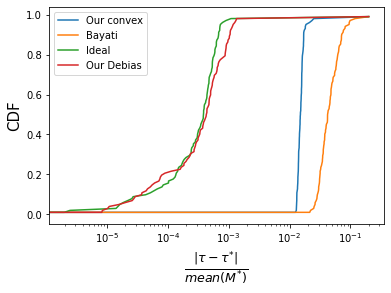

In [510]:
def process_and_plot(file_path, scenario='synthetic'):
    df = pickle.load(open(file_path, 'rb'))
    if (scenario == 'synthetic'):
        df = df / 20
        display(df[['tau_convex', 'tau_missing', 'tau_ideal', 'tau_debias']].describe())
    else:
        df = df / 4319.0149
        display(df[['tau_convex', 'tau_missing', 'tau_trivial', 'tau_debias']].describe())


    ### plot and process the data

    #### plot the cdf
    

    def plot_cdf(str_name):
        tau = sorted(np.array(df[str_name]))
        tau = np.concatenate(([xmin], tau))
        tau = np.concatenate((tau, [xmax]))
        plt.plot(tau, np.arange(0, len(tau)) / len(tau))

    if (scenario == 'synthetic'):
        xmin = 0
        xmax = 0.2
        plot_cdf('tau_convex')
        plot_cdf('tau_missing')
        plot_cdf('tau_ideal')
        plot_cdf('tau_debias')

        plt.ylabel('CDF', fontsize = 15)
        plt.xlabel(r'$\frac{|\tau - \tau^{*}|}{mean(M^{*})}$', fontsize = 18)
        plt.xscale('log')
        plt.legend(['Our convex', 'Bayati', 'Ideal', 'Our Debias'])

    else:
        xmin = 0
        xmax = 0.9
        plot_cdf('tau_convex')
        plot_cdf('tau_missing')
        plot_cdf('tau_trivial')
        plot_cdf('tau_debias')

        plt.ylabel('CDF', fontsize = 15)
        plt.xlabel(r'$\frac{|\tau - \tau^{*}|}{mean(M^{*})}$', fontsize = 18)
        plt.xscale('log')
        plt.legend(['Our convex', 'Bayati', 'Trivial', 'Our Debias'])

file_path = 'data_2020-11-11-05-24.p'
process_and_plot(file_path)

## Quick experiment on the real beer data

In [427]:
df = pd.read_csv(open('data/beer_filter.csv'))
beer_data = np.array(df.drop(['ID'], axis = 1))
beer_data.shape

(393, 245)

In [508]:
def real_data_experiment(M0, suggest_r = 50, tau_range = 1000, num_experiment = 10, file_path = 'data.p'):
    data = np.zeros((num_experiment, 8))
    for i in range(num_experiment):
        print('experiments', i)

        #E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #Z = np.random.rand(n, n) <= p_treat
        #Z = np.zeros((n,n))
        #Z[:int(n/2), :int(n/2)] = 1

        a = np.random.randint(50)+5
        b = np.random.randint(50)+5


        Z = adpative_treatment_pattern(a, b, M0)
        p_treat = np.random.rand()*0.5
        #Z = np.random.rand(M0.shape[0], M0.shape[1]) <= p_treat
        Z = np.zeros((M0.shape[0],M0.shape[1]))
        ratio = np.random.rand()*0.8
        Z[:int(n*ratio), :int(n*ratio)] = 1
        tau_star = np.random.rand()*tau_range
        print(a, b, tau_star)
        print('********sparsity is', np.sum(Z)/Z.size)

        O = M0 + Z * tau_star

        M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = suggest_r)
        M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
        print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
        print('tau is {}, tau_star is {}'.format(tau, tau_star))
        print('debiase', abs(tau_debias - tau_star))
        print('trivial', np.sum(M0*Z)/np.sum(Z) - np.sum(M0*(1-Z))/np.sum(1-Z))

        #print('ideal error is {}'.format(ideal_algorithm(E, Z)))

        M_m, tau_m = tune_missing_algorithm_with_rank(O, 1-Z, fixed_effects=True, suggest_r=suggest_r)
        M_m_F, M_m_oo, tau_m_error = error_metric(M_m, tau_m, M0, tau_star)
        print('Missing algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_m_F, M_m_oo, tau_m_error))

        data[i,0] = tau_error
        data[i,1] = M_F
        data[i, 2] = M_oo
        data[i,3] = tau_m_error
        data[i, 4] = M_m_F
        data[i, 5] = M_m_oo
        data[i, 6] = abs(np.sum(M0*Z)/np.sum(Z) - np.sum(M0*(1-Z))/np.sum(1-Z))
        data[i, 7] = abs(tau_debias - tau_star)

    df = pd.DataFrame(data, columns = ['tau_convex', 'F_convex', 'Inf_convex', 'tau_missing', 'F_missing', 'Inf_missing', 'tau_trivial', 'tau_debias'])
    pickle.dump(df, open(file_path, 'wb'))
    return df


#M0 = beer_data
#print(np.mean(M0))
df = real_data_experiment(beer_data, num_experiment = 50)
display(df)


# tau_star = 1000
# #Z = adpative_treatment_pattern(10, 20, M0)
# Z = np.random.rand(M0.shape[0], M0.shape[1]) <= 0.1
# O = M0 + tau_star*Z
# #l = 0.8*1e5
# l = 1000
# M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = 50)
# #M, tau, info = convex_algorithm(O, np.ones_like(Z), Z, 10)
# M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
# print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
# print('tau is {}, tau_star is {}'.format(tau, tau_star))
# print('debias', tau_debias)

# print('trivial', np.sum(M0*Z)/np.sum(Z) - np.sum(M0*(1-Z))/np.sum(1-Z))

# M_m, tau_m = tune_missing_algorithm_with_rank(O, 1-Z, fixed_effects=True, suggest_r= 50)
# M_m_F, M_m_oo, tau_m_error = error_metric(M_m, tau_m, M0, tau_star)
# print('Missing algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_m_F, M_m_oo, tau_m_error))
# #M, tau = tune_convex_algorithm_with_rank(O, Z, suggest_r = 30)

7, tau_star is 429.334862305213
debiase 254.82924103096633
trivial 2683.0336986202087
14263.398890552018 42
Missing algorithm: Frobenious error 0.018839574182414498, entrywise error 0.337477431034045, tau_error 1936.5123588339634
experiments 8
28 44 990.0815097076672
********sparsity is 0.17016149971438957
successful 14048.061597664459 43
Frobenious error 0.0016219770998805894, entrywise error 0.047189038603803996, tau_error 495.0049383465155
tau is 1485.0864480541827, tau_star is 990.0815097076672
debiase 53.083793059732216
trivial 1736.6164076141536
15421.25124643616 40
Missing algorithm: Frobenious error 0.03691215775402525, entrywise error 0.38121908374318786, tau_error 1717.855485570106
experiments 9
29 37 579.8111129995087
********sparsity is 0.007571272783922729
successful 13534.397909181256 43
Frobenious error 0.0011848570755349478, entrywise error 0.043218476266095825, tau_error 67.04689745721475
tau is 646.8580104567235, tau_star is 579.8111129995087
debiase 10.54150242539196

,tau_convex,F_convex,Inf_convex,tau_missing,F_missing,Inf_missing,tau_trivial,tau_debias
0,141.967326,0.001188,0.043234,5.597352,0.001277,0.042611,773.235322,185.750867
1,516.784241,0.001603,0.046865,1644.467865,0.031367,0.355468,1897.473521,43.669852
2,473.869903,0.001278,0.043447,592.089197,0.002170,0.067161,442.310928,87.687060
3,770.171164,0.001672,0.043572,1971.446973,0.019565,0.342399,2738.717931,294.977010
4,128.993186,0.001183,0.043190,133.476948,0.001163,0.042869,1592.984001,135.691955
5,501.145255,0.001292,0.043557,603.866621,0.002166,0.067165,519.171928,87.536774
6,675.844577,0.001738,0.043948,1671.435023,0.027396,0.344375,2238.341279,12.465100
7,759.056057,0.001648,0.043529,1936.512359,0.018840,0.337477,2683.033699,254.829241
8,495.004938,0.001622,0.047189,1717.855486,0.036912,0.381219,1736.616408,53.083793
9,67.046897,0.001185,0.043218,69.130924,0.001225,0.042804,212.585030,10.541502


,tau_convex,tau_missing,tau_trivial,tau_debias
count,50.000000,50.000000,50.000000,50.000000
mean,0.118793,0.338398,0.367420,0.036952
std,0.055977,0.265941,0.216262,0.044664
min,0.003975,0.000581,0.021372,0.000586
25%,0.082457,0.131313,0.163399,0.010919
50%,0.118111,0.383873,0.388622,0.019901
75%,0.162863,0.431674,0.574090,0.041884
max,0.220805,0.825089,0.705920,0.178899


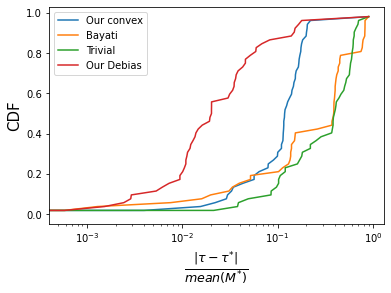

In [511]:
file_path = 'data_2020-11-12-03-21.p'
file_path = 'data.p'
process_and_plot(file_path, scenario='real-data')

In [356]:
u, s, vh = np.linalg.svd(Z, full_matrices = False)

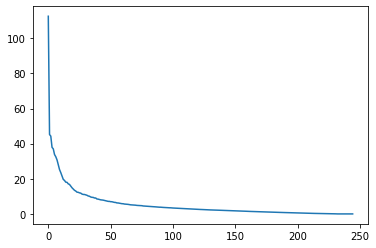

In [357]:
plt.plot(s)

In [495]:
M0 = beer_data
s = np.zeros((100,1))
for i in range(100):
        print('experiments', i)

        #E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #Z = np.random.rand(n, n) <= p_treat
        #Z = np.zeros((n,n))
        #Z[:int(n/2), :int(n/2)] = 1

        a = np.random.randint(50)+5
        b = np.random.randint(50)+5

        Z = adpative_treatment_pattern(a, b, M0)
#        tau_star = np.random.rand()*tau_range
        print(a, b)
        print('********sparsity is', np.sum(Z)/Z.size)
        s[i] = np.sum(Z)/Z.size

experiments 0
24 21
********sparsity is 0.3281819598068235
experiments 1
34 31
********sparsity is 0.3167367710442956
experiments 2
36 40
********sparsity is 0.3508646206574233
experiments 3
24 30
********sparsity is 0.4009866542036662
experiments 4
22 18
********sparsity is 0.30230046216960066
experiments 5
34 14
********sparsity is 0.2004777483512489
experiments 6
35 7
********sparsity is 0.10554084229111492
experiments 7
6 23
********sparsity is 0.6336708729293244
experiments 8
10 37
********sparsity is 0.6381783247650206
experiments 9
54 35
********sparsity is 0.23551955133198318
experiments 10
23 28
********sparsity is 0.4132523238302955
experiments 11
13 47
********sparsity is 0.6205743366048709
experiments 12
53 11
********sparsity is 0.08849768915199667
experiments 13
22 33
********sparsity is 0.43917536480240954
experiments 14
23 25
********sparsity is 0.383258036038843
experiments 15
9 20
********sparsity is 0.510681829983902
experiments 16
6 22
********sparsity is 0.62253725

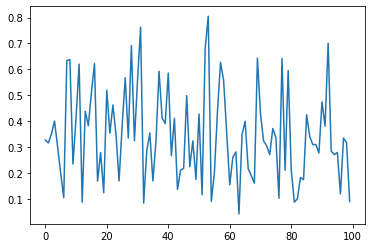

In [497]:
s = s[:100]
plt.plot(s)

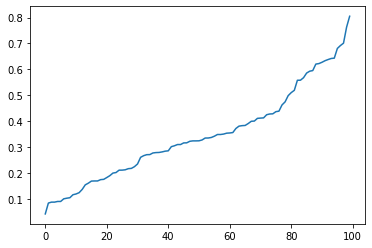

In [499]:
plt.plot(sorted(s))

In [500]:
np.mean(s)

0.3460860985615621